In [1]:
# import gymnasium as gym
import gym
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt
import imageio
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/pradeep/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem-1: DQN

#### (a)

In [2]:
env = gym.make("MountainCar-v0")
print("Three actions: Accelerate to the left , Dont Accelerate, Accelerate to the right -> " , env.action_space.n)
print("State space comprises of position of car along x axis and velocity of car  -> ", env.observation_space) 

print("\nRandom agent to understand reward and states: \n")
state, _ = env.reset()

for i in range(5):

    action = env.action_space.sample()
    next_state, reward, terminated, trucated, _ = env.step(action)
    
    print(f'state: {state}')
    print(f'action: {action}')
    print(f'next state: {next_state}')
    print(f'reward: {reward}\n')

    state = next_state

    if(terminated or trucated):
        state, _ = env.reset()

Three actions: Accelerate to the left , Dont Accelerate, Accelerate to the right ->  3
State space comprises of position of car along x axis and velocity of car  ->  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

Random agent to understand reward and states: 

state: [-0.58946246  0.        ]
action: 0
next state: [-5.8997166e-01 -5.0923054e-04]
reward: -1.0

state: [-5.8997166e-01 -5.0923054e-04]
action: 1
next state: [-5.8998638e-01 -1.4716761e-05]
reward: -1.0

state: [-5.8998638e-01 -1.4716761e-05]
action: 0
next state: [-5.9050649e-01 -5.2009476e-04]
reward: -1.0

state: [-5.9050649e-01 -5.2009476e-04]
action: 1
next state: [-5.9052813e-01 -2.1649792e-05]
reward: -1.0

state: [-5.9052813e-01 -2.1649792e-05]
action: 2
next state: [-0.5890512   0.00147695]
reward: -1.0



In [3]:
env = gym.make("ALE/Pong-v5")
print("Six actions: NOOP , Fire , Right , Left , RightFire , LeftFire -> " , env.action_space)
print("State space comprises all RGB images -> ", env.observation_space) 

print("\nRandom agent to understand reward and states: \n")
state, _ = env.reset()

for i in range(5):

    action = env.action_space.sample()
    next_state, reward, terminated, trucated, _ = env.step(action)
    
    print(f'state: {state.shape}')
    print(f'action: {action}')
    print(f'next state: {next_state.shape}')
    print(f'reward: {reward}\n')

    state = next_state

    if(terminated or trucated):
        state, _ = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Six actions: NOOP , Fire , Right , Left , RightFire , LeftFire ->  Discrete(6)
State space comprises all RGB images ->  Box(0, 255, (210, 160, 3), uint8)

Random agent to understand reward and states: 

state: (210, 160, 3)
action: 0
next state: (210, 160, 3)
reward: 0.0

state: (210, 160, 3)
action: 3
next state: (210, 160, 3)
reward: 0.0

state: (210, 160, 3)
action: 4
next state: (210, 160, 3)
reward: 0.0

state: (210, 160, 3)
action: 5
next state: (210, 160, 3)
reward: 0.0

state: (210, 160, 3)
action: 0
next state: (210, 160, 3)
reward: 0.0



#### (b)

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity=10000):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class network(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(network, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)


    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
class DQN():

    def __init__(self, env, replay_memory_size=100000, num_episodes=1000, lr=1e-3, batch_size=200, gamma=0.99, eps=0.9, eps_decay=0.995, eps_min=1e-3, update_target = 5):

        self.env = env
        state, _ = self.env.reset()
        self.n_observation = len(state)
        self.n_action = env.action_space.n

        self.Q_net = network(self.n_observation, self.n_action).to(device)
        self.target_net = network(self.n_observation, self.n_action).to(device)
        self.target_net.load_state_dict(self.Q_net.state_dict())

        self.replay_memory = ReplayMemory(replay_memory_size)
        self.lr = lr
        self.optimizer = optim.Adam(self.Q_net.parameters(), self.lr)

        self.batch_size = batch_size
        self.time_steps = 200
        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.update_target = update_target

        if torch.cuda.is_available():
            self.num_episodes = num_episodes
        else:
            self.num_episodes = min(1000, num_episodes)
        
        return

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=device)
        self.Q_net.eval()

        with torch.no_grad():
            Q = self.Q_net(state)
        
        self.Q_net.train()
        actions = [self.eps/Q.size()[0] for i in range(Q.size()[0])]
        actions[torch.argmax(Q).item()] += 1 - self.eps

        self.eps = max(self.eps*self.eps_decay, self.eps_min)

        return torch.argmax(Q).item()
    

    def optimize(self):

        batch = self.replay_memory.sample(self.batch_size)
        batch = Transition(*zip(*batch))
        
        self.Q_net.train()
        self.target_net.eval()

        state_batch = torch.cat(batch.state, dim=0).reshape(self.batch_size, self.n_observation)
        action_batch = torch.tensor(batch.action)
        reward_batch = torch.tensor(batch.reward)

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).reshape([-1,2])

        state_action_values = self.Q_net(state_batch)
        state_action_values = state_action_values[range(state_action_values.size(0)), action_batch]
        
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]

        expected_state_action_values = reward_batch + self.gamma * next_state_values # Yi's

        criterion = torch.nn.MSELoss()
        loss = criterion(state_action_values, expected_state_action_values)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self.Q_net.parameters(), 100)
        self.optimizer.step()

        return

    def train(self):
        step = 0
        avg_rewards = []
        best_rewards = []
        state, _ = self.env.reset()

        for i in range(self.batch_size):
            state = self.env.observation_space.sample()
            state = torch.tensor(state, dtype=torch.float32, device=device)
            action = self.select_action(state)
            next_state, reward, terminated, trucated, _ = self.env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
            self.replay_memory.push(state, action, next_state, reward)

        
        for episode in range(self.num_episodes):

            state, _ = self.env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device)

            tot_reward = 0

            for t in range(self.time_steps):

                action = self.select_action(state)
                next_state, reward, terminated, trucated, _ = self.env.step(action)

                tot_reward += reward
                step += 1

                if terminated or trucated: 
                    next_state = None
                else:
                    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)

                self.replay_memory.push(state, action, next_state, reward)

                state = next_state

                self.optimize()

                if step % self.update_target == 0:
                    self.target_net.load_state_dict(self.Q_net.state_dict())
                
                if terminated or trucated:
                    break
            
            if episode%10==0:
                print(f'episode: {episode}')
                test_rewards = []
                state, _ = self.env.reset()
                state = torch.tensor(state, dtype=torch.float32, device=device)

                for i in range(10):
                    r = 0.0
                    while True:
                        action = self.select_action(state)
                        next_state, reward, terminated, trucated, _ = self.env.step(action)
                        r += reward
                        next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
                        state = next_state
                        if terminated or trucated:
                            break
                    test_rewards.append(r)
                test_rewards = torch.tensor(test_rewards, dtype=torch.float32)
                avg_rewards.append(test_rewards.mean().item())
                best_rewards.append(test_rewards.max().item())
            
        return avg_rewards, best_rewards

In [7]:
env = gym.make("MountainCar-v0", render_mode='rgb_array_list')
model = DQN(env)
avg_rewards, best_rewards = model.train()

/tmp/ipykernel_6884/4245001517.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


episode: 0
episode: 10
episode: 20
episode: 30
episode: 40
episode: 50
episode: 60
episode: 70
episode: 80
episode: 90
episode: 100
episode: 110
episode: 120
episode: 130
episode: 140
episode: 150
episode: 160
episode: 170
episode: 180
episode: 190
episode: 200
episode: 210
episode: 220
episode: 230
episode: 240
episode: 250
episode: 260
episode: 270
episode: 280
episode: 290
episode: 300
episode: 310
episode: 320
episode: 330
episode: 340
episode: 350
episode: 360
episode: 370
episode: 380
episode: 390
episode: 400
episode: 410
episode: 420
episode: 430
episode: 440
episode: 450
episode: 460
episode: 470
episode: 480
episode: 490
episode: 500
episode: 510
episode: 520
episode: 530
episode: 540
episode: 550
episode: 560
episode: 570
episode: 580
episode: 590
episode: 600
episode: 610
episode: 620
episode: 630
episode: 640
episode: 650
episode: 660
episode: 670
episode: 680
episode: 690
episode: 700
episode: 710
episode: 720
episode: 730
episode: 740
episode: 750
episode: 760
episode: 7

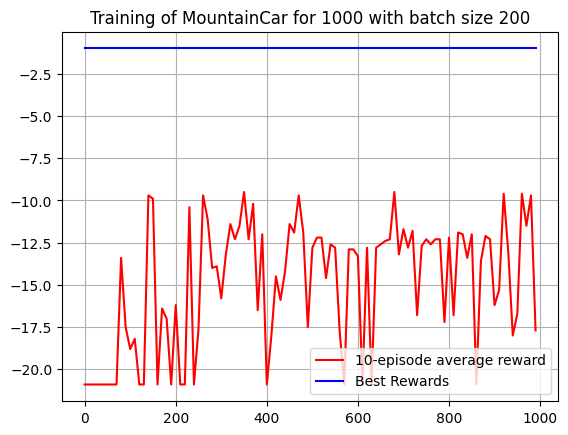

In [8]:
x = torch.arange(0 , model.num_episodes, 10)
plt.plot(x , avg_rewards , 'r-' , label = "10-episode average reward")
plt.plot(x , best_rewards , 'b-' , label = "Best Rewards")
plt.title(f"Training of MountainCar for {model.num_episodes} with batch size {model.batch_size}")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
state, _ = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device)
images = []

while True:
    # images.append(env.render())
    action = model.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)

    if terminated or truncated:
        break

    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
    state = next_state

images = env.render()
print(len(images))
imageio.mimsave('mountain_car.gif', images, fps=len(images)/3)

/tmp/ipykernel_6884/4245001517.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


92


![SegmentLocal](mountain_car.gif)

#### (c)

/tmp/ipykernel_6884/4245001517.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device)


episode: 0
episode: 10
episode: 20
episode: 30
episode: 40
episode: 50
episode: 60
episode: 70
episode: 80
episode: 90
episode: 100
episode: 110
episode: 120
episode: 130
episode: 140
episode: 150
episode: 160
episode: 170
episode: 180
episode: 190
episode: 200
episode: 210
episode: 220
episode: 230
episode: 240
episode: 250
episode: 260
episode: 270
episode: 280
episode: 290
episode: 300
episode: 310
episode: 320
episode: 330
episode: 340
episode: 350
episode: 360
episode: 370
episode: 380
episode: 390
episode: 400
episode: 410
episode: 420
episode: 430
episode: 440
episode: 450
episode: 460
episode: 470
episode: 480
episode: 490
episode: 500
episode: 510
episode: 520
episode: 530
episode: 540
episode: 550
episode: 560
episode: 570
episode: 580
episode: 590
episode: 600
episode: 610
episode: 620
episode: 630
episode: 640
episode: 650
episode: 660
episode: 670
episode: 680
episode: 690
episode: 700
episode: 710
episode: 720
episode: 730
episode: 740
episode: 750
episode: 760
episode: 7

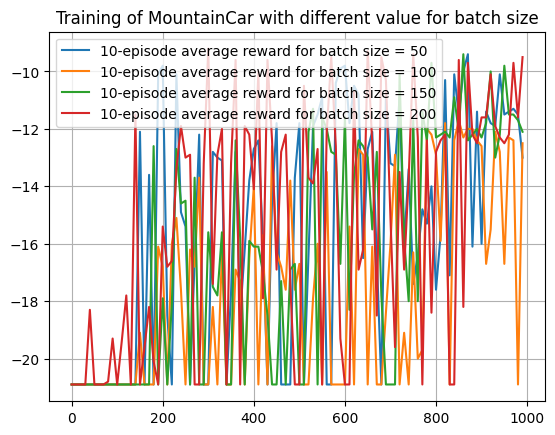

In [10]:
batch_sizes = [50, 100, 150, 200]

plt.title(f"Training of MountainCar with different value for batch size")

for batch_size in batch_sizes:
    env = gym.make("MountainCar-v0")
    model = DQN(env, batch_size=batch_size)
    avg_rewards, best_rewards = model.train()
    x = torch.arange(0 , model.num_episodes, 10)
    plt.plot(x , avg_rewards , label = f"10-episode average reward for batch size = {batch_size}")
    # plt.plot(x , best_rewards , 'b-' , label = "Best Rewards")

plt.grid(True)
plt.legend()
plt.show()